# Sample Points from COLMAP just relating to Image Number 100

In [3]:
from splat.read_colmap import read_images_text, qvec2rotmat
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "treehill/sparse/0"

reconstruction = pycolmap.Reconstruction(colmap_path)
test = False

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

# we will only use points from image_num 100
image_num = 100

image = images[image_num]
points_in_3d = []
points2d = []
colors2d = []
for idx, point in enumerate(image.xys):
    point3d_id = image.point3D_ids[idx]
    if point3d_id > 0:
        try:
            color = points3d[point3d_id].color
            points_in_3d.append(points3d[point3d_id].xyz)
            points2d.append(point)
            colors2d.append(color)
        except:
            pass

points_in_3d = np.array(points_in_3d)
points2d = np.array(points2d)
colors2d = np.array(colors2d)

gaussians = Gaussians(
    torch.Tensor(points_in_3d), torch.Tensor(colors2d), model_path="point_clouds"
)

# Plot their 2d location - this is what we will seek to recreate

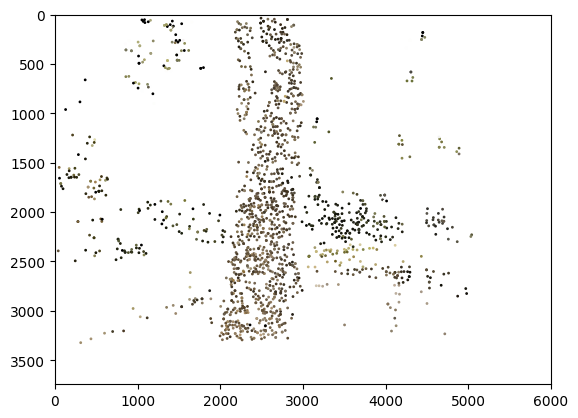

In [4]:
import matplotlib.pyplot as plt

scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d / 256, s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()

# Project points to 2d using the intrinsic and extrinsic matrices

torch.Size([1697, 3])


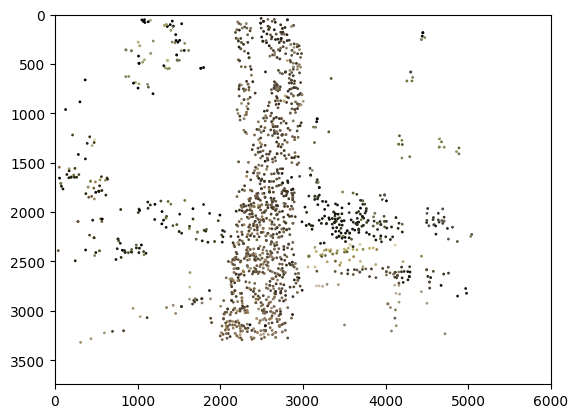

In [5]:
with torch.no_grad():
    points, colors = scene.render_points_image(image_num)

print(points.shape)
plt.scatter(points[:, 0].cpu(), points[:, 1].cpu(), c=colors.cpu(), s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()

# Render Image with Gaussians

100%|██████████| 2533/2533 [00:45<00:00, 55.36it/s] 


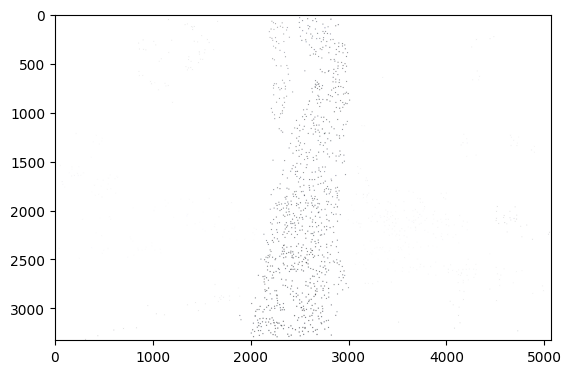

In [6]:
image = scene.render_image(image_num, tile_size=2)
import matplotlib.pyplot as plt

# Assuming new_image is your image tensor

# Set background to white
new_image = image * (image > 0.001).float()
new_image[new_image <= 0.001] = 1

# Display the image
plt.imshow(new_image.detach().transpose(0, 1), cmap="gray", vmin=0, vmax=1)
plt.show()

In [7]:
# note there are points in the white space that we just cannot see because of resolution
image[:1000].max()

tensor(0.7134, grad_fn=<MaxBackward1>)

# Now we will render the whole scene

In [8]:
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D

all_points3d = []
all_point_colors = []

for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path="point_clouds",
)
scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

/var/folders/5t/lqp_tbx57bl8lb0cbbxb2sv80000gn/T/ipykernel_76811/3931605071.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  torch.Tensor(all_points3d),


# Renders all points in the scene with our projection matrices

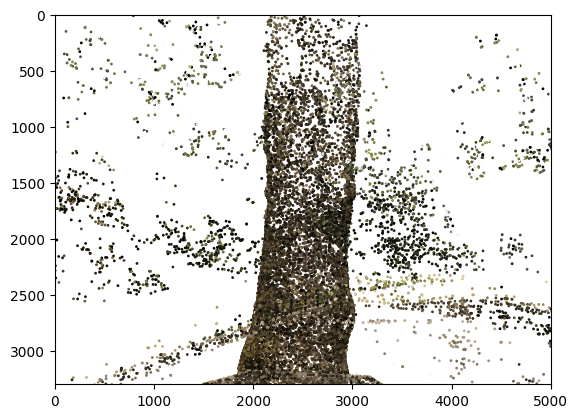

In [13]:
from matplotlib import pyplot as plt

image_num = 100

processed_scene = scene.preprocess(image_num)
plt.scatter(
    processed_scene.points_xy[:, 0].detach().cpu(),
    processed_scene.points_xy[:, 1].detach().cpu(),
    c=processed_scene.colors.detach().cpu(),
    s=1,
)
plt.xlim(0, 5000)
plt.ylim(0, 3300)
plt.gca().invert_yaxis()

# Uses our rendering engine to render pixel by pixel

100%|██████████| 316/316 [06:11<00:00,  1.18s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


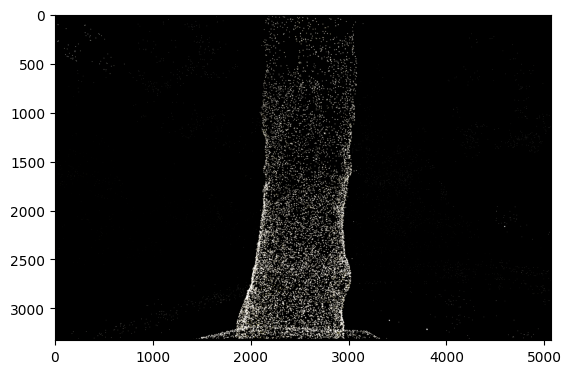

In [14]:
# this may take a while

# Note only pixels with high density (around tree trunk) are shown as our variance for each Gaussian is quite low meaning points have to be near each other to show

with torch.no_grad():
    image = scene.render_image(image_num)

plt.imshow(image.cpu().detach().transpose(0, 1) * 256)

In [17]:
(image.cpu().detach().transpose(0, 1) * 256).save("treehill.png")

AttributeError: 'Image' object has no attribute 'cpu'

In [16]:
# convert and save as image
from PIL import Image

image = (image.cpu().detach().transpose(0, 1) * 256).numpy().astype(np.uint8)
image = Image.fromarray(image)
image.save("treehill.png")

In [ ]:
def render_image(self, image_idx: int, tile_size: int = 16) -> torch.Tensor:
    """For each tile have to check if the point is in the tile"""
    preprocessed_scene = self.preprocess(image_idx)
    height = self.images[image_idx].height
    width = self.images[image_idx].width

    image = torch.zeros((width, height, 3))

    for x_min in tqdm(range(0, width, tile_size)):
        x_in_tile = (x_min >= preprocessed_scene.min_x) & (
            x_min + tile_size <= preprocessed_scene.max_x
        )
        if x_in_tile.sum() == 0:
            continue
        for y_min in range(0, height, tile_size):
            y_in_tile = (y_min >= preprocessed_scene.min_y) & (
                y_min + tile_size <= preprocessed_scene.max_y
            )
            points_in_tile = x_in_tile & y_in_tile
            if points_in_tile.sum() == 0:
                continue
            points_in_tile_mean = preprocessed_scene.points[points_in_tile]
            colors_in_tile = preprocessed_scene.colors[points_in_tile]
            opacities_in_tile = preprocessed_scene.sigmoid_opacity[points_in_tile]
            inverse_covariance_in_tile = preprocessed_scene.inverse_covariance_2d[
                points_in_tile
            ]
            image[x_min : x_min + tile_size, y_min : y_min + tile_size] = (
                self.render_tile(
                    x_min=x_min,
                    y_min=y_min,
                    points_in_tile_mean=points_in_tile_mean,
                    colors=colors_in_tile,
                    opacities=opacities_in_tile,
                    inverse_covariance=inverse_covariance_in_tile,
                    tile_size=tile_size,
                )
            )
    return image